In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def hkl1(const):
    from math import sqrt
    
    for h in range(51):
        
        if h ** 2 > const:
            raise ValueError('h^2 > const; couldn\'t find an appropriate Miller plane')
        
        for k in range(51):
            
            if k ** 2 > const:
                break
            
            l = sqrt(const - h ** 2 - k ** 2)
            
            if l % 1 == 0:
                
                temp = [h, k, int(l)]
                temp.sort(reverse=True)
                
                return np.array(temp)

In [3]:
def hkl(arr):
    
    miller = []
    
    #Obtain the set of Miller planes for every Bragg peak
    for i, const in enumerate(arr):
        miller.append(hkl1(const) )
    
    miller = np.array(miller)
    labels = miller.astype(np.str_)
    labels = [''.join(i).join( ('{', '}') ) for i in labels]
    
    return miller, labels

In [4]:
def plot_data(dd, const):
    from numpy.polynomial import Polynomial as P
    from numpy.polynomial.polynomial import polyfit
    import matplotlib.pyplot as plt
    
    a = polyfit(const, dd, 1)[1]
    
    bestfit = P.fit(const, dd, 1)
    x, y = bestfit.linspace(domain=[0, bestfit.domain[1]])
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.scatter(const, dd, label='actual data')
    ax.plot(x, y, label='line of best fit')
    
    ax.set_xlim(0)
    ax.set_ylim(0)
    
    ax.set_xlabel(r'$h^{2}$ +' + r' $k^{2}$ +' + r' $l^{2}$', fontsize=15)
    ax.set_ylabel(r'$\frac{1}{d^{2}}$  /$\frac{1}{Å^2}$', fontsize=15)
    
    plt.legend(fontsize=15)
    
    plt.show()
    
    return a

In [26]:
def analyse_diffraction(data, lamda, angle=2, **kwargs):
    """
    Given the angles from diffraction experiment, indexes the results, determines the unit Bravais lattice and 
    calculates unit cell length.
    
    Parameters
    ----------
    data : str or array_like
        Input data - θ values of Bragg peaks
    lamda : float or int
        The wavelength of the x-ray used in the scattering experiment.
        Must be in units of nm
    angle : int or float, optional
        The multiplier of the inputted θ values; if data is not the scattering angle but its multiple,
        angle will be used to divide the inputted data so as to obtain the true scattering angle θ.
        Default = 2, i.e. the default data is as 2θ.
    kwargs : chemical symbol of element = int
        Used to check if the atoms in the solid are close in atomic number or if the ions in the solid are
        isoelectronic. In those cases, normal x-ray scattering experiments are not precise enough to distinguish
        the atoms, so a warning is issues that the predicted unit cell may not be correct.
    
    Returns
    -------
    - calculated unit cell
    - warning if appropriate (see kwargs)
    - plot of 1/d**2 against plane parameters
    - unit cell length
    df : Pandas DataFrame containing the indexing
    """
    from math import sqrt
    from itertools import combinations
    
    from mendeleev import element
    from SigFigRounding import RoundToSigFigs_fp
    
    decimals = len(str(lamda).split('.')[1]) #determine the number of decimals in lamda
        #this will be used to round the resuls of each calculation to an appropriate number of
        #significant figures so as to maintain a consistent degree of accuracy.
    
    #first change data into a usable format
    if type(data) is str:
        
        if data.find('\n') != -1: #deal with data in separate lines
            data = data.splitlines()
            data = np.array([float(i.replace(',', '').strip()) for i in data])
            
        else: #deal with data separated by unknown numbers of spaces
            data = data.replace(',', '').split(' ')
            data = np.array(list(filter(lambda x: x != ' ', data) ))
    
    else:
        data = np.array(data)
    
    d = RoundToSigFigs_fp(lamda / (2 * np.sin(np.radians(data / angle) ) ), decimals) #obtain d using Bragg equation
    cubicd = RoundToSigFigs_fp(1 / d ** 2, decimals) #assume the unit cell is cubic
    const = RoundToSigFigs_fp(cubicd / np.amin(cubicd), 3) #divide all values by the smallest to eliminate a
    
    
    
    #Names for dataframe columns
    name1 = r'$$\frac{1}{d^{2}}  /\frac{1}{Å^2}$$'
    name2 = r'$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$'
    
    #If h2 + k2 + l2 = integer, prcoeed as-is; if not, try to find an integer that will mutliple the const so that it
    ##becomes an integer
    if (np.absolute(const - np.round(const))  <= 0.05).all():
        
        const2 = np.round(const).astype(np.int64)
        miller, labels = hkl(const2) #obtain miller planes
        
        df =  pd.DataFrame({'2θ': data, 'd /Å': d, name1: cubicd, r'$$\frac{1}{d^2} /const$$': const, 
                            name2: const2, 'Index': labels})
        
    else:
        
        #look for an integer i such that i * const = integer
        for i in range(2, 101):
            
            const2 = const * i
            if (np.absolute(const2 - np.round(const2))  < 0.05).all():
                break
        
        const3 = np.round(const2).astype(np.int64)
        miller, labels = hkl(const3) #obtain Miller planes
        
        df =  pd.DataFrame({'2θ': data, 'd /Å': d, name1: cubicd, r'$$\frac{1}{d^2} /const$$': const, 
                            r'$$\frac{1}{d^2} /constant$$': const2, name2: const3, 'Index': labels})
        
        const = const2 #bring the actual value to array of name consistent with the other option
    
    
    
    if np.array([(i % 2 == 0 ).all() or (i % 2 == 1).all() for i in miller]).all() == True:
        #Material is fcc if each set of h, k, l is all odd or all even.
        print('This material has a face-centered cubic unit cell.')
    
    elif (np.sum(miller, axis=1) % 2 == 0).all() == True:
        #Material is bcc if the sum of each set of h, k, l is an even number.
        print('This material has a body-centered cubic unit cell.')
    
    else:
        print('This material has a primitive cubic unit cell.')
    
    
    
    #Use provided atoms and charges to determine if the atoms are close in atomic number or if ions are isoelectronic:
    if kwargs:
        
        atoms = element(list(kwargs.keys() ) ) #retrieve the specified atoms
        electrons = np.array([i.atomic_number for i in atoms]) #retrieve the atomic number of all atoms
        electrons = electrons - np.array(list(kwargs.values() ) ) #obtain the number of electrons of each atom
        
        for i in combinations([j for j, __ in enumerate(electrons) ], 2):
            
            if abs(electrons[i[0] ] - electrons[i[1] ] ) < 2:
                print(f'However, {atoms[i[0] ].name} and {atoms[i[1] ].name} have similar number'
                     + ' of electrons, and therefore due to limitations of X-ray diffraction, '
                     + 'the two atoms are indistinguishable. If that is the case, the returned unit'
                     + ' cell is more symmetric than the actual unit cell of the material.')
        
        
    
    
    a = plot_data(cubicd, const)
    
    print('a = ', RoundToSigFigs_fp(sqrt(a ** -1), decimals), ' Å')
    
    return df

This material has a face-centered cubic unit cell.


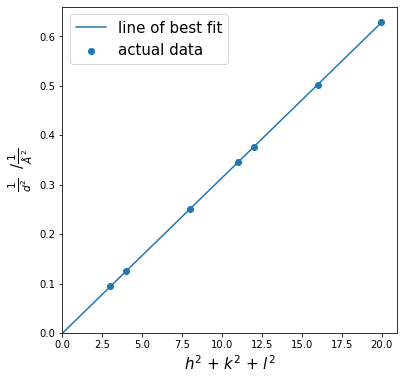

a =  5.642  Å


,2θ,d /Å,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,$$\frac{1}{d^2} /const$$,$$\frac{1}{d^2} /constant$$,$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$,Index
0,27.38,3.257,0.09427,1.00,3.00,3,{111}
1,31.72,2.821,0.12570,1.33,3.99,4,{200}
2,45.47,1.995,0.25130,2.67,8.01,8,{220}
3,53.89,1.701,0.34560,3.67,11.01,11,{311}
4,56.50,1.629,0.37680,4.00,12.00,12,{222}
5,66.26,1.411,0.50230,5.33,15.99,16,{400}
6,75.33,1.262,0.62790,6.66,19.98,20,{420}


In [27]:
analyse_diffraction([27.38, 31.72, 45.47, 53.89, 56.50, 66.26, 75.33], 1.5418, Na=1, Cl=-1)

This material has a primitive cubic unit cell.
However, Potassium and Chlorine have similar number of electrons, and therefore due to limitations of X-ray diffraction, the two atoms are indistinguishable. If that is the case, the returned unit cell is more symmetric than the actual unit cell of the material.


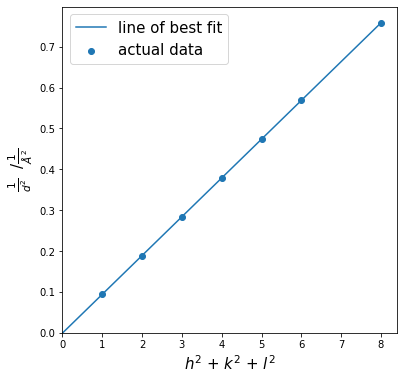

a =  3.249  Å


,2θ,d /Å,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,$$\frac{1}{d^2} /const$$,$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$,Index
0,27.46,3.248,0.09479,1.00,1,{100}
1,39.22,2.297,0.18950,2.00,2,{110}
2,48.54,1.875,0.28440,3.00,3,{111}
3,56.68,1.624,0.37920,4.00,4,{200}
4,64.10,1.453,0.47370,5.00,5,{210}
5,71.09,1.326,0.56870,6.00,6,{211}
6,84.33,1.148,0.75880,8.01,8,{220}


In [28]:
analyse_diffraction([27.46,   39.22,   48.54,   56.68,   64.10,   71.09,   84.33], 1.5418, K=1, Cl=-1)

This material has a primitive cubic unit cell.


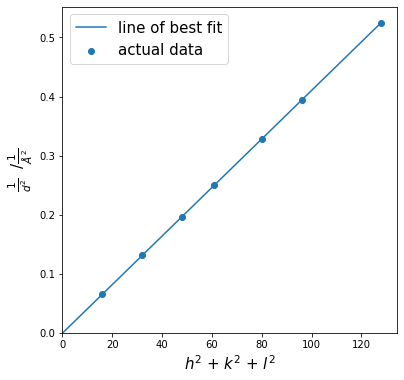

a =  15.61  Å


,2θ,d /Å,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,$$\frac{1}{d^2} /const$$,$$\frac{1}{d^2} /constant$$,$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$,Index
0,22.783,3.903,0.06565,1.00,16.00,16,{400}
1,32.440,2.760,0.13130,2.00,32.00,32,{440}
2,40.010,2.253,0.19700,3.00,48.00,48,{444}
3,45.353,2.000,0.25000,3.81,60.96,61,{650}
4,52.419,1.745,0.32840,5.00,80.00,80,{840}
5,57.865,1.593,0.39410,6.00,96.00,96,{844}
6,67.925,1.380,0.52510,8.00,128.00,128,{880}


In [29]:
analyse_diffraction([22.783,   32.44,   40.01,   45.353,   52.419,   57.865,   67.925], 1.5418)

This material has a primitive cubic unit cell.
However, Copper and Zinc have similar number of electrons, and therefore due to limitations of X-ray diffraction, the two atoms are indistinguishable. If that is the case, the returned unit cell is more symmetric than the actual unit cell of the material.


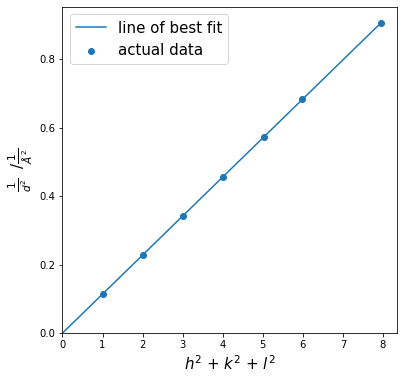

a =  2.96  Å


,2θ,d /Å,$$\frac{1}{d^{2}} /\frac{1}{Å^2}$$,$$\frac{1}{d^2} /const$$,$$h^{2} \:+\: k^{2} \:+ \: l^{2}$$,Index
0,31.472,2.96,0.114,1.00,1,{100}
1,45.107,2.09,0.229,2.01,2,{110}
2,56.035,1.71,0.342,3.00,3,{111}
3,65.696,1.48,0.457,4.01,4,{200}
4,74.665,1.32,0.574,5.04,5,{210}
5,83.260,1.21,0.683,5.99,6,{211}
6,100.186,1.05,0.907,7.96,8,{220}


In [30]:
analyse_diffraction([31.472,  45.107,  56.035,  65.696,  74.665,  83.260,  100.186],  1.605, Cu=0, Zn=0)